In [1]:
import pandas as pd
import numpy as np
from pulp import *
dat = '11-05'

In [2]:
file1 = ('https://github.com/ZTFisme/Data-Sets/blob/main/NBA_Advanced_Player_Data.xlsx?raw=true')
file2 = ('https://github.com/ZTFisme/Data-Sets/blob/main/NBA_Traditional_Player_Data.xlsx?raw=true')
file3 = ('https://github.com/ZTFisme/Data-Sets/blob/main/Opponent_List.xlsx?raw=true')
file4 = ('https://github.com/ZTFisme/Data-Sets/blob/main/Yahoo_DFS_Cost.xlsx?raw=true')

In [3]:
adv = pd.read_excel(file1, sheet_name = 0, header=0)
trad = pd.read_excel(file2, sheet_name = 0, header = 0)
opponent = pd.read_excel(file3, sheet_name = 0, header=0)
opponent = opponent[['TEAM',dat]].rename(columns={dat:'OPP'})
cost = pd.read_excel(file4, sheet_name = dat, header=0)
cost = cost[['PLAYER', 'POSITION', 'COST']]
positions = pd.read_excel(file3, sheet_name = 'Positions', header = 0)

In [4]:
import nba_api
from nba_api.stats.endpoints import playergamelogs
from datetime import timedelta
from datetime import datetime
from dateutil import parser

max_date = parser.parse(max(trad['GAME_DATE']))
date_from = (max_date + timedelta(days=1)).date().strftime('%m-%d-%y')

trad_logs = pd.DataFrame() 
advanced_logs = pd.DataFrame()
    
tradlog = playergamelogs.PlayerGameLogs( season_nullable= '2021-22', measure_type_player_game_logs_nullable = nba_api.stats.library.parameters.MeasureTypePlayerGameLogs.base)
tlogs = tradlog.get_data_frames()[0]
trad_logs = trad_logs.append(tlogs)

advlogs = playergamelogs.PlayerGameLogs(season_nullable= '2021-22', measure_type_player_game_logs_nullable = nba_api.stats.library.parameters.MeasureTypePlayerGameLogs.advanced)
alogs = advlogs.get_data_frames()[0]
advanced_logs = advanced_logs.append(alogs)

In [5]:
advanced_logs = advanced_logs[list(adv.columns)]
trad_logs = trad_logs[list(trad.columns)]
trad = trad.append(trad_logs).drop_duplicates().reset_index(drop=True)
adv = adv.append(advanced_logs).drop_duplicates().reset_index(drop=True)

In [6]:
def clean_data(trad, adv, positions):
    HA_lst = []
    opp_lst = []
    for i in range(len(trad)):
        game = trad.iloc[i]['MATCHUP']
        if '@' in game:
            HA_lst.append("Away")
            team, opp = game.split(' @ ')
            opp_lst.append(opp)
        else:
            HA_lst.append("Home")
            team, opp = game.split(' vs. ')
            opp_lst.append(opp)
    trad['H_A'] = HA_lst
    trad['OPP'] = opp_lst
    trad = trad.merge(positions, left_on='PLAYER_NAME', right_on='PLAYER')
    trad['OPP_POS'] = trad['OPP'] + '-' + trad['POSITION']
    ha_lst= []
    for i in range(len(trad)):
        if trad.iloc[i]['H_A'] == 'Home':
            ha_lst.append(1)
        else:
            ha_lst.append(0)
    trad['HOME_AWAY'] = ha_lst
    data = trad.merge(adv, how='right', on=['GAME_ID','TEAM_ID','PLAYER_ID'], suffixes=('', '_drop'))

    data.drop([col for col in data.columns if 'drop' in col], axis=1, inplace=True)
    data = data.dropna().drop_duplicates().reset_index(drop=True).rename(columns = {'NBA_FANTASY_PTS':'FPTS'})
    data['NEW_STAT'] = data['MIN'] * data['USG_PCT'] * data['PACE'] / 100
    data = data[data['MIN']!=0].reset_index(drop=True).rename(columns = {'TEAM_ABBREVIATION':'TEAM'})
    data['SMA2'] = data.groupby('PLAYER')['FPTS'].transform(lambda x: x.rolling(2,1).mean())
    data['SMA2_STAT'] = data.groupby('PLAYER')['NEW_STAT'].transform(lambda x: x.rolling(2,1).mean())
    data['FPTS/MIN'] = data['FPTS'] / data ['MIN']

    player_stats = pd.DataFrame(data.groupby('PLAYER')['FPTS','FPTS/MIN'].mean())
    last = pd.DataFrame(data.set_index('PLAYER').groupby(level='PLAYER').agg(['last']).stack())
    last = last.reset_index()[['PLAYER','POSITION','TEAM','SMA2', 'SMA2_STAT']]
    l = last.merge(player_stats, how='inner', left_on = 'PLAYER', right_on = 'PLAYER').rename(columns={'FPTS':'AVG_FPTS'})
    l_avg = l[['PLAYER','AVG_FPTS']]
    data = data.merge(l_avg)
    data['PTS_DIFF'] = data['FPTS'] - data['AVG_FPTS']

    opp_pos = data.groupby(['OPP','POSITION','OPP_POS'])['PTS_DIFF','FPTS', 'FPTS/MIN'].mean().reset_index()
    opp_c = opp_pos[opp_pos['POSITION']=='C'].reset_index(drop=True)
    opp_pf = opp_pos[opp_pos['POSITION']=='PF'].reset_index(drop=True)
    opp_sf = opp_pos[opp_pos['POSITION']=='SF'].reset_index(drop=True)
    opp_sg = opp_pos[opp_pos['POSITION']=='SG'].reset_index(drop=True)
    opp_pg = opp_pos[opp_pos['POSITION']=='PG'].reset_index(drop=True)

    def opp_process(opp):
        fpts_mu = opp['FPTS'].mean()
        diff_mu = opp['PTS_DIFF'].mean()
        fpts_min_mu = opp['FPTS/MIN'].mean()

        opp['FPTS_AGST_AVG'] = ''
        opp['DIFF_AGST_AVG'] = ''
        opp['FPTS_MIN_AGST_AVG'] = ''

        for i in range(len(opp)):
            fpt = opp.iloc[i]['FPTS'] / fpts_mu
            diff = opp.iloc[i]['PTS_DIFF'] - diff_mu
            fpts_min = opp.iloc[i]['FPTS/MIN'] / fpts_min_mu
            opp.at[i, 'FPTS_AGST_AVG'] = fpt
            opp.at[i, 'DIFF_AGST_AVG'] = diff
            opp.at[i, 'FPTS_MIN_AGST_AVG'] = fpts_min
        return opp

    opp_pg = opp_process(opp_pg)
    opp_sg = opp_process(opp_sg)
    opp_sf = opp_process(opp_sf)
    opp_pf = opp_process(opp_pf)
    opp_c = opp_process(opp_c)

    opps = [opp_pg, opp_sg, opp_sf, opp_pf, opp_c]
    opponents = pd.concat(opps).reset_index(drop=True)
    opponents = opponents[['OPP_POS','DIFF_AGST_AVG']].rename(columns = {'DIFF_AGST_AVG':'OPP_DIFF_AGST_AVG'})
    data = data.merge(opponents, on = 'OPP_POS')
    data = data.sort_values(by=['PLAYER_NAME','GAME_DATE'])
    return data

In [7]:
data = clean_data(trad, adv, positions)


C:\Users\zacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\zacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [84]:
data

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,POSS,FGM_PG,FGA_PG,NEW_STAT,SMA2,SMA2_STAT,FPTS/MIN,AVG_FPTS,PTS_DIFF,OPP_DIFF_AGST_AVG
9040,2018-19,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,21800006,2018-10-17T00:00:00,ORL vs. MIA,...,80,9.0,18.0,9.975503,36.60,7.429657,1.154047,30.220297,13.979703,-0.599209
6542,2018-19,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,21800017,2018-10-19T00:00:00,ORL vs. CHA,...,56,2.0,9.0,4.883811,37.95,6.327934,1.164659,30.220297,-1.220297,0.546584
8204,2018-19,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,21800029,2018-10-20T00:00:00,ORL @ PHI,...,64,7.0,12.0,7.772057,33.00,6.862609,1.460301,30.220297,16.679703,-0.314835
7389,2018-19,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,21800040,2018-10-22T00:00:00,ORL @ BOS,...,79,5.0,11.0,5.953161,22.45,6.261113,0.495032,30.220297,-11.120297,-0.300309
12009,2018-19,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,21800064,2018-10-25T00:00:00,ORL vs. POR,...,56,6.0,11.0,6.569064,22.90,6.943416,0.907918,30.220297,-4.420297,1.02736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,2020-21,1629627,Zion Williamson,Zion,1610612740,NOP,New Orleans Pelicans,22000940,2021-04-28T00:00:00,NOP @ DEN,...,76,8.0,17.0,10.615265,37.50,10.703837,0.853908,40.555294,-14.155294,-0.941518
6472,2020-21,1629627,Zion Williamson,Zion,1610612740,NOP,New Orleans Pelicans,22000947,2021-04-29T00:00:00,NOP @ OKC,...,77,12.0,24.0,10.792409,53.70,11.882366,1.420776,40.555294,8.044706,1.41527
1942,2020-21,1629627,Zion Williamson,Zion,1610612740,NOP,New Orleans Pelicans,22000962,2021-05-01T00:00:00,NOP @ MIN,...,95,14.0,17.0,12.972324,51.95,13.401100,1.403341,40.555294,18.244706,0.141541
8971,2020-21,1629627,Zion Williamson,Zion,1610612740,NOP,New Orleans Pelicans,22000977,2021-05-03T00:00:00,NOP vs. GSW,...,84,12.0,24.0,13.829877,49.50,12.280027,1.222940,40.555294,4.544706,-0.0348525


,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,POSS,FGM_PG,FGA_PG,NEW_STAT,SMA2,SMA2_STAT,FPTS/MIN,AVG_FPTS,PTS_DIFF,OPP_DIFF_AGST_AVG
9047,2020-21,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,22000012,2020-12-23T00:00:00,ORL vs. MIA,...,57,8.0,11.0,6.730511,34.35,6.381808,1.476923,30.220297,8.179703,-0.599209
11161,2020-21,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,22000024,2020-12-26T00:00:00,ORL @ WAS,...,67,6.0,12.0,6.033105,20.75,4.148749,1.021922,30.220297,0.079703,0.274548
11160,2020-21,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,22000033,2020-12-27T00:00:00,ORL @ WAS,...,43,1.0,4.0,2.264393,17.60,4.267284,0.565657,30.220297,-19.020297,0.274548
6144,2020-21,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,22000052,2020-12-29T00:00:00,ORL @ OKC,...,49,5.0,10.0,6.270174,19.55,5.858485,1.082707,30.220297,-6.220297,1.41527
8208,2020-21,203932,Aaron Gordon,Aaron,1610612753,ORL,Orlando Magic,22000064,2020-12-31T00:00:00,ORL vs. PHI,...,45,1.0,8.0,5.446795,23.60,5.906954,0.725380,30.220297,-15.120297,-0.314835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,2020-21,1629627,Zion Williamson,Zion,1610612740,NOP,New Orleans Pelicans,22000940,2021-04-28T00:00:00,NOP @ DEN,...,76,8.0,17.0,10.615265,37.50,10.703837,0.853908,40.555294,-14.155294,-0.941518
6472,2020-21,1629627,Zion Williamson,Zion,1610612740,NOP,New Orleans Pelicans,22000947,2021-04-29T00:00:00,NOP @ OKC,...,77,12.0,24.0,10.792409,53.70,11.882366,1.420776,40.555294,8.044706,1.41527
1942,2020-21,1629627,Zion Williamson,Zion,1610612740,NOP,New Orleans Pelicans,22000962,2021-05-01T00:00:00,NOP @ MIN,...,95,14.0,17.0,12.972324,51.95,13.401100,1.403341,40.555294,18.244706,0.141541
8971,2020-21,1629627,Zion Williamson,Zion,1610612740,NOP,New Orleans Pelicans,22000977,2021-05-03T00:00:00,NOP vs. GSW,...,84,12.0,24.0,13.829877,49.50,12.280027,1.222940,40.555294,4.544706,-0.0348525


In [35]:
'MIN', 'FGA',  'FG3A', 'FTA', 'PFD', 'HOME_AWAY', 'AST_PCT', 'AST_TO',  'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 
        'PIE', 'POSS', 'FGM_PG', 'FGA_PG', 'NEW_STAT', 'FPTS/MIN', 'AVG_FPTS',  'OPP_DIFF_AGST_AVG'

('PFD', 'AST_TO', 'REB_PCT', 'FGM_PG')

In [110]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_data = data[data['SEASON_YEAR']=='2020-21']
X = np.array(train_data[['MIN', 'PFD',  'AST_PCT',  
       'REB_PCT', 'FGM_PG', 'AVG_FPTS']])
y = np.array(train_data['FPTS'])

#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)
train_r_sq = model.score(X_train, y_train)
r_sq = model.score(X_test, y_test)
print('r squared value:', r_sq)
print('intercept:', model.intercept_)
    #print('coefficients:', model.coef_)

cdf = pd.DataFrame(model.coef_, ['MIN', 'PFD', 'AST_PCT',  
       'REB_PCT', 'FGM_PG', 'AVG_FPTS'], columns=['Coefficients'])
print(cdf)

r squared value: 0.8842428437506938
intercept: -5.5196832388492005
          Coefficients
MIN           0.427977
PFD           0.859809
AST_PCT      14.493992
REB_PCT      37.186068
FGM_PG        2.222174
AVG_FPTS      0.077039


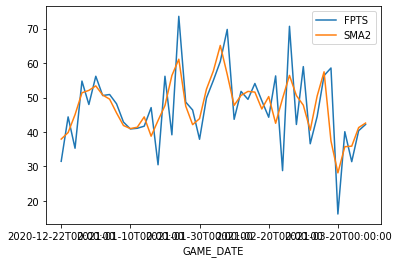

In [114]:
train_data[train_data['PLAYER_NAME']=='LeBron James'].plot(x='GAME_DATE', y = ['FPTS','SMA2'])

In [7]:
def update_model(data):

    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    X = np.array(data[['SMA2',  'NEW_STAT']])
    y = np.array(data['FPTS'])

    #scaler = StandardScaler().fit(X)
    #X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression().fit(X_train, y_train)
    r_sq = model.score(X_test, y_test)
    print('r squared value:', r_sq)
    print('intercept:', model.intercept_)
    #print('coefficients:', model.coef_)

    cdf = pd.DataFrame(model.coef_, ['SMA2',  'SMA2_STAT'], columns=['Coefficients'])
    print(cdf)
    sma_coef = model.coef_[0]
    new_stat_coef = model.coef_[1]
    return sma_coef, new_stat_coef

In [8]:
def prepare_predictions(data, opponent, cost, sma_coef, new_stat_coef):
    player_stats = pd.DataFrame(data.groupby('PLAYER')['FPTS','FPTS/MIN'].mean())
    last = pd.DataFrame(data.set_index('PLAYER').groupby(level='PLAYER').agg(['last']).stack())
    last = last.reset_index()[['PLAYER','POSITION','TEAM','SMA2', 'SMA2_STAT']]
    l = last.merge(player_stats, how='inner', left_on = 'PLAYER', right_on = 'PLAYER').rename(columns={'FPTS':'AVG_FPTS'})
    
    opp_pos = data.groupby(['OPP','POSITION','OPP_POS'])['PTS_DIFF','FPTS', 'FPTS/MIN'].mean().reset_index()
    opp_c = opp_pos[opp_pos['POSITION']=='C'].reset_index(drop=True)
    opp_pf = opp_pos[opp_pos['POSITION']=='PF'].reset_index(drop=True)
    opp_sf = opp_pos[opp_pos['POSITION']=='SF'].reset_index(drop=True)
    opp_sg = opp_pos[opp_pos['POSITION']=='SG'].reset_index(drop=True)
    opp_pg = opp_pos[opp_pos['POSITION']=='PG'].reset_index(drop=True)

    def opp_process(opp):
        fpts_mu = opp['FPTS'].mean()
        diff_mu = opp['PTS_DIFF'].mean()
        fpts_min_mu = opp['FPTS/MIN'].mean()

        opp['FPTS_AGST_AVG'] = ''
        opp['DIFF_AGST_AVG'] = ''
        opp['FPTS_MIN_AGST_AVG'] = ''

        for i in range(len(opp)):
            fpt = opp.iloc[i]['FPTS'] / fpts_mu
            diff = opp.iloc[i]['PTS_DIFF'] - diff_mu
            fpts_min = opp.iloc[i]['FPTS/MIN'] / fpts_min_mu
            opp.at[i, 'FPTS_AGST_AVG'] = fpt
            opp.at[i, 'DIFF_AGST_AVG'] = diff
            opp.at[i, 'FPTS_MIN_AGST_AVG'] = fpts_min
        return opp

    opp_pg = opp_process(opp_pg)
    opp_sg = opp_process(opp_sg)
    opp_sf = opp_process(opp_sf)
    opp_pf = opp_process(opp_pf)
    opp_c = opp_process(opp_c)

    opps = [opp_pg, opp_sg, opp_sf, opp_pf, opp_c]
    opponents = pd.concat(opps).reset_index(drop=True)
    opponents = opponents[['OPP_POS','DIFF_AGST_AVG']].rename(columns = {'DIFF_AGST_AVG':'OPP_DIFF_AGST_AVG'})
    
    oppo = l.merge(opponent, how='inner', left_on = 'TEAM', right_on = 'TEAM')
    oppo['OPP_POS'] = oppo['OPP'] + '-' + oppo['POSITION']
    pred = oppo.merge(opponents, how = 'inner', left_on='OPP_POS', right_on = 'OPP_POS')
    pred = pred.rename(columns={'OPP_x':'OPP','POSITION_x':'POSITION'})
    pred['PRED'] = (  (pred['SMA2']*sma_coef) + (pred['SMA2_STAT'] * new_stat_coef) + (pred['OPP_DIFF_AGST_AVG']))
    pred = pred.merge(cost, how = 'inner', left_on = 'PLAYER', right_on = 'PLAYER')
    pred = pred.drop(columns = ["POSITION_x"]).rename(columns = {"POSITION_y":"POSITION"})
    import re
    player_lst = []
    for i in range(len(pred)):
        player_lst.append(re.sub('-',' ',pred['PLAYER'][i]))
    pred['PLAYER'] = player_lst
    return pred

In [9]:
def optimize_predictions(pred):
    df = pred
    def pg_id(x):
        if x=='PG':
            return 1
        else:
            return 0
    def sg_id(x):
        if x=='SG':
            return 1
        else:
            return 0
    def sf_id(x):
        if x=='SF':
            return 1
        else:
            return 0
    def pf_id(x):
        if x=='PF':
            return 1
        else:
            return 0
    def c_id(x):
        if x=='C':
            return 1
        else:
            return 0

    df['PG'] = df['POSITION'].apply(pg_id)
    df['SG'] = df['POSITION'].apply(sg_id)
    df['SF'] = df['POSITION'].apply(sf_id)
    df['PF'] = df['POSITION'].apply(pf_id)
    df['C'] = df['POSITION'].apply(c_id)
    df['COST'] = [float(i) for i in df['COST']]

    #Clean data and convert to list- only look at rows with diet data and not constraint information
    df = df.where(df['COST'] > 0)
    df = df.dropna()
    df = df.values.tolist()

    players = [x[0] for x in df]
    cost = dict([(x[0], float(x[11])) for x in df])
    position = dict([(x[0], x[10]) for x in df])
    proj_pts = dict([(x[0], float(x[9])) for x in df])

    pg = dict([(x[0], float(x[12])) for x in df])
    sg = dict([(x[0], float(x[13])) for x in df])
    sf = dict([(x[0], float(x[14])) for x in df])
    pf = dict([(x[0], float(x[15])) for x in df])
    c = dict([(x[0], float(x[16])) for x in df])

    player_vars = LpVariable.dicts("Player", players, cat = "Integer", lowBound= 0, upBound = 1)

    # create the optimization problem framework - maximize points while meeting requirements of maximum cost
    prob = LpProblem("NBA_Optimize", LpMaximize)

    #Define objective function for projected points
    obj_func = lpSum([proj_pts[i] * player_vars[i] for i in players])
    prob += obj_func

    #Number of player choices constraint
    constraint_2 = lpSum([player_vars[i] for i in player_vars]) == 8
    prob += constraint_2 

    #Cost Constraint
    constraint_3 = lpSum([cost[f] * player_vars[f] for f in player_vars]) <= 200.0
    prob += constraint_3

    #Position Constraints
    #PG
    prob += lpSum([pg[f] * player_vars[f] for f in player_vars]) >= 1
    prob += lpSum([pg[f] * player_vars[f] for f in player_vars]) <= 3

    #SG
    prob += lpSum([sg[f] * player_vars[f] for f in player_vars]) >= 1
    prob += lpSum([sg[f] * player_vars[f] for f in player_vars]) <= 3

    #G
    prob += lpSum([(pg[f] * player_vars[f]) + (sg[f] * player_vars[f]) for f in player_vars]) >= 3
    prob += lpSum([(pg[f] * player_vars[f]) + (sg[f] * player_vars[f]) for f in player_vars]) <= 4

    #SF
    prob += lpSum([sf[f] * player_vars[f] for f in player_vars]) >= 1
    prob += lpSum([sf[f] * player_vars[f] for f in player_vars]) <= 3

    #PF
    prob += lpSum([pf[f] * player_vars[f] for f in player_vars]) >= 1
    prob += lpSum([pf[f] * player_vars[f] for f in player_vars]) <= 3

    #F
    prob += lpSum([(sf[f] * player_vars[f]) + (pf[f] * player_vars[f]) for f in player_vars]) >= 3
    prob += lpSum([(sf[f] * player_vars[f]) + (pf[f] * player_vars[f]) for f in player_vars]) <= 4

    #C
    prob += lpSum([c[f] * player_vars[f] for f in player_vars]) >= 1
    prob += lpSum([c[f] * player_vars[f] for f in player_vars]) <= 2

    #Solve the Objective Function
    prob.solve()
    name_lst = []
    import re
    for x in prob.variables():
        if x.varValue>0:
            nm = x.name
            name_lst.append(re.sub(r'[_]',' ',nm[7:]))
    lineup = pd.DataFrame(name_lst).rename(columns={0:'PLAYER'})
    lineup = lineup.merge(pred, how = 'inner', left_on = 'PLAYER', right_on = 'PLAYER')
    lineup = lineup[['PLAYER', 'POSITION', 'SMA2', 'SMA2_STAT', 'AVG_FPTS', 'COST', 'PRED']]
    print('The Projected Total Points are: ', sum(lineup['PRED']))
    return lineup


In [10]:
data = clean_data(trad, adv, positions)
sma_coef, new_stat_coef = update_model(data)
pred = prepare_predictions(data, opponent, cost, sma_coef, new_stat_coef)
lineup = optimize_predictions(pred)
lineup

r squared value: 0.8376967785129512
intercept: -0.5227502515945588
           Coefficients
SMA2           0.724869
SMA2_STAT      1.418664
The Projected Total Points are:  350.0650378054799


,PLAYER,POSITION,SMA2,SMA2_STAT,AVG_FPTS,COST,PRED
0,CJ McCollum,SG,49.55,10.909737,35.442640,32.0,51.4925
1,Devin Vassell,SF,32.50,5.561833,14.405479,12.0,31.7692
2,Evan Fournier,SG,40.90,8.416057,27.390000,22.0,42.1414
3,Gordon Hayward,SF,39.85,9.880837,29.793889,24.0,42.937
4,Jarrett Allen,C,51.35,7.961613,29.732889,26.0,46.2402
5,Jordan Poole,SG,37.50,9.562853,17.911864,21.0,41.139
6,Julius Randle,PF,49.70,12.703731,40.323288,42.0,54.1418
7,Reggie Jackson,PG,37.50,8.877895,22.865608,21.0,40.2039


In [153]:
data['SMA2'] = data.groupby('PLAYER')['FPTS'].transform(lambda x: x.rolling(2,2).mean())
data['EWM2'] = (data.groupby(['PLAYER'])['FPTS'].transform(lambda x: x.ewm(span=2,min_periods=2,adjust=False,ignore_na=False).mean()))

In [169]:
data[['SMA2','EWM2','FPTS']]

,SMA2,EWM2,FPTS
0,NaN,NaN,44.2
1,36.60,34.066667,29.0
2,37.95,42.622222,46.9
3,33.00,26.940741,19.1
4,22.45,26.180247,25.8
...,...,...,...
68404,27.55,29.149194,26.4
68405,37.50,42.116398,48.6
68406,53.70,53.238799,58.8
68407,51.95,47.812933,45.1


In [167]:
data.groupby(['PLAYER'])['FPTS'].shift(1)

0         NaN
1        44.2
2        29.0
3        46.9
4        19.1
         ... 
68404    28.7
68405    26.4
68406    48.6
68407    58.8
68408    45.1
Name: FPTS, Length: 68409, dtype: float64

In [172]:
tab = pd.DataFrame(columns = ['Type','K-Value', 'RSFE', 'ME', 'MAD', 'MSD', 'TS'])

for k in range(2,11):
    forecast = data.groupby('PLAYER')['FPTS'].transform(lambda x: x.rolling(k,k).mean()).shift(1)
    E = (data['FPTS'] - forecast)
    MAD = (forecast - data['FPTS']).abs()
    MSD = (forecast - data['FPTS']).abs().pow(2)
    tab.at[k-1, 'Type'] = 'SMA'
    tab.at[k-1, 'K-Value'] = k
    tab.at[k-1, 'RSFE'] = E.sum(skipna=True)
    tab.at[k-1, 'ME'] = np.nanmean(E)
    tab.at[k-1, 'MAD'] = np.nanmean(MAD)
    tab.at[k-1, 'MSD'] = np.nanmean(MSD)
    tab.at[k-1, 'TS'] = E.sum(skipna=True) / MAD.mean()
    
    ema = (data.groupby(['PLAYER'])['FPTS'].transform(lambda x: x.ewm(span=k,min_periods=k,adjust=False,ignore_na=False).mean())).shift(1) 
    ema_E = (data['FPTS'] - ema)
    ema_MAD = (ema - data['FPTS']).abs()
    ema_MSD = (ema - data['FPTS']).abs().pow(2)
    tab.at[k+9, 'Type'] = 'EMA'
    tab.at[k+9, 'K-Value'] = k
    tab.at[k+9, 'RSFE'] = ema_E.sum(skipna=True)
    tab.at[k+9, 'ME'] = np.nanmean(ema_E)
    tab.at[k+9, 'MAD'] = np.nanmean(ema_MAD)
    tab.at[k+9, 'MSD'] = np.nanmean(ema_MSD)
    tab.at[k+9, 'TS'] = ema_E.sum(skipna=True) / np.nanmean(ema_MAD)
print ('\033[1m' + 'Moving Average Forecasts:\n')
tab.sort_values(by='MAD',ascending=True).reset_index(drop=True)

Moving Average Forecasts:



,Type,K-Value,RSFE,ME,MAD,MSD,TS
0,EMA,10,820.887,0.0129819,7.84765,101.561,104.603
1,EMA,9,655.954,0.0102848,7.85288,101.862,83.5303
2,EMA,8,915.619,0.0142329,7.86623,102.363,116.399
3,EMA,7,913.215,0.0140722,7.89159,103.23,115.72
4,EMA,6,905.396,0.0138302,7.92991,104.449,114.175
5,SMA,10,-314.13,-0.00496782,7.98325,104.772,-39.3486
6,SMA,9,-228.422,-0.00358146,7.98669,104.986,-28.6004
7,EMA,5,584.691,0.00885333,7.98965,106.273,73.1811
8,SMA,8,241.375,0.00375208,7.996,105.285,30.187
9,SMA,7,435.1,0.00670468,8.01209,106.01,54.3054


In [115]:
tab = pd.DataFrame(columns = ['Type','K-Value', 'RSFE', 'ME', 'MAD', 'MSD', 'TS'])

for k in range(2,11):
    forecast = data.groupby('PLAYER')['NEW_STAT'].transform(lambda x: x.rolling(k,k-1).mean())
    E = (data['NEW_STAT'] - forecast).fillna(0)
    MAD = (forecast - data['NEW_STAT']).abs()
    MSD = (forecast - data['NEW_STAT']).abs().pow(2)
    tab.at[k-1, 'Type'] = 'SMA'
    tab.at[k-1, 'K-Value'] = k
    tab.at[k-1, 'RSFE'] = sum(E)
    tab.at[k-1, 'ME'] = E.mean()
    tab.at[k-1, 'MAD'] = MAD.mean()
    tab.at[k-1, 'MSD'] = MSD.mean()
    tab.at[k-1, 'TS'] = sum(E) / MAD.mean()
    
    ema = (data.groupby(['PLAYER'])['NEW_STAT'].transform(lambda x: x.ewm(span = k, min_periods = k-1).mean()))
    ema_E = (data['NEW_STAT'] - ema).fillna(0)
    ema_MAD = (ema - data['NEW_STAT']).abs()
    ema_MSD = (ema - data['NEW_STAT']).abs().pow(2)
    tab.at[k+9, 'Type'] = 'EMA'
    tab.at[k+9, 'K-Value'] = k
    tab.at[k+9, 'RSFE'] = sum(ema_E)
    tab.at[k+9, 'ME'] = ema_E.mean()
    tab.at[k+9, 'MAD'] = ema_MAD.mean()
    tab.at[k+9, 'MSD'] = ema_MSD.mean()
    tab.at[k+9, 'TS'] = sum(ema_E) / ema_MAD.mean()
print ('\033[1m' + 'Moving Average Forecasts:\n')
tab.sort_values(by='MAD',ascending=True).reset_index(drop=True)

Moving Average Forecasts:



,Type,K-Value,RSFE,ME,MAD,MSD,TS
0,EMA,2,85.9798,0.00125685,0.493933,0.428134,174.072
1,EMA,3,154.247,0.00225477,0.713967,0.881444,216.042
2,SMA,2,102.961,0.00150509,0.837398,1.24549,122.954
3,EMA,4,214.045,0.0031289,0.840558,1.21538,254.646
4,EMA,5,192.017,0.0028069,0.924374,1.46432,207.727
5,EMA,6,238.709,0.00348944,0.984772,1.65817,242.4
6,SMA,3,176.213,0.00257587,1.01119,1.76979,174.263
7,EMA,7,251.444,0.00367559,1.0305,1.81211,244.001
8,EMA,8,310.923,0.00454506,1.06731,1.94047,291.316
9,SMA,4,241.286,0.00352711,1.092,2.04937,220.958
